Collecting Network Statistics in Pytorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The purpose is to load generated trained models from the Autoencoder implementation and collect encoding statistics for analysis.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math
import numpy

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#if torch.cuda.is_available():
#    platform = "cuda"
#else:
#    platform = "cpu"
platform = "cpu"
print(platform)

cpu


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 32

code_sides = [16]

model_path = "../../Data/OPTIMAM_NEW/model0.pt"

#image_count = 500
image_count = -1

## Dataset

ImageFolder is used to load the base distribution images. This version of the DataLoader setup is designed to not batch or shuffle the images as we load them sequentially

In [4]:
from torchvision.datasets import ImageFolder

from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
     torchvision.transforms.Grayscale(),
     torchvision.transforms.Resize((height,width)),
     torchvision.transforms.ToTensor()
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images"
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
    print("setting image count to " + str(image_count))
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, shuffle=False
)

setting image count to 8889


### Autoencoder

We have to load the same encoding setup as in our autoencoder. (We'll set this up as an include in a bit.)

In [5]:
class SplitAutoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x32x128
            nn.Flatten(), # 131072x1
            nn.Linear(in_features=32*32*128,out_features=kwargs["code_size"]),
            nn.ReLU()
        )
        # result (encoding) is code_size x 1
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=kwargs["code_size"], out_features=32*32*128), #131072x1
            nn.Unflatten(1,(128,32,32)), # 32x32x128
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 128x128x32
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), #256x256x1
        )
        
    def forward(self, features):
        code = self.encoder(features)
        out = self.decoder(code)
        return out

Before using our defined autoencoder class, we have the following things to do:
    1. We configure which device we want to run on.
    2. We instantiate our modules.
    3. We define our optimizer.
    4. We define our reconstruction loss.

In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

# reload the saved model

model = torch.load(model_path,map_location=device)
model.eval()

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

losses = [None] * len(train_dataset_subset)
encodings = [None] * len(train_dataset_subset)

We run our autoencoder on the entire dataset and store the encodings

In [ ]:
with torch.no_grad():
    count = 0
    for batch_features, labels in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # compute reconstructions
        code = model.encoder(batch_features)
        outputs = model.decoder(code)
        
        code_reshaped = code.detach().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(outputs,batch_features)

        losses[count] = error_criterion.numpy()

        count = count + 1

And calculate the encoding statistics:

In [44]:
print(len(encodings))
print(len(encodings[0]))
print(len(losses))

8889
256
8889


In [27]:
feature_means = np.mean(encodings,axis=0)
feature_stds = np.std(encodings,axis=0)
print(len(feature_means))
print(len(feature_stds))

mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
print("MSE Min/Mean/Max:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max))

256
256
MSE Min/Mean/Max:0.00014829007/0.001179785/0.0037938775


Now we save the compiled statistics to an excel file.

In [11]:
with torch.no_grad():
    np_losses = np.asarray(losses)

    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    np.savetxt('encodings.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('losses.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('combined.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Generate Adversarials


The next stage is to create a set of adversarial images. For this, we will use the same ImageFolder dataset as before. However, we will use a different Transform stack - with the same basic elements, plus a set of transforms intended to generate aberrational images.

In [149]:
with torch.no_grad():
    trigger_chance = 0.8

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=15,translate=(0.4,0.4),shear=60),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.GaussianBlur(kernel_size=5),
        torchvision.transforms.ColorJitter(brightness=0.8,contrast=0.8)
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([
         torchvision.transforms.Grayscale(),
         torchvision.transforms.Resize((height,width)),
         PIL_transforms,
         torchvision.transforms.ToTensor(),
         torchvision.transforms.RandomErasing(p=trigger_chance),
        ])

    adversarial_image_count = 5

    adversarial_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=adversarial_transform)

    adversarial_subset = torch.utils.data.Subset(adversarial_dataset, numpy.random.choice(len(adversarial_dataset), adversarial_image_count, replace=False))

    adversarial_loader = torch.utils.data.DataLoader(
        adversarial_subset, batch_size=1, shuffle=True
    )
    
    adv_example_sets = np.zeros((5,height,width))
    adv_code_sets = np.zeros((5,256))
    reconstruction_sets = np.zeros((5,height,width))

Now run the model on these adversarial images:

In [150]:
with torch.no_grad():
    i = 0
    for batch_features in adversarial_loader:
        batch_features = batch_features[0]
        adv_example = batch_features.to(device)
        n_code = model.encoder(adv_example)
        reconstruction = model(adv_example)
    
        adv_example_sets[i] = adv_example
        adv_code_sets[i] = n_code
        reconstruction_sets[i] = reconstruction
        i += 1

Next, measure the loss and feature statistics for the adversarials:            

In [151]:
mse_array = ((reconstruction_sets - adv_example_sets)**2)
mse = np.apply_over_axes(np.mean, mse_array, (1, 2))
print(len(mse))
print(mse)
#sum_mse = np.sum(mse[0])
#print(sum_mse)

5
[[[0.0057493 ]]

 [[0.0053175 ]]

 [[0.03605576]]

 [[0.08965485]]

 [[0.00751469]]]


In [152]:
g = np.ma.masked_equal(feature_stds,0)

adv_divergence = (adv_code_sets - feature_means) / g
print(np.max(adv_divergence,axis=1))

[0.5803620757293714 1.7087082468399506 4.000103045725735
 4.6237485214469505 1.5255865156885786]


And plot the results:

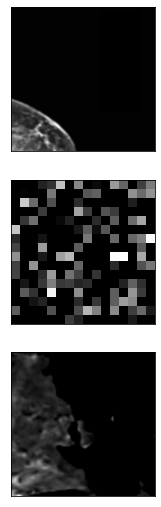

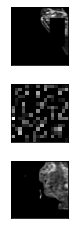

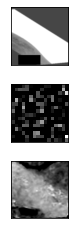

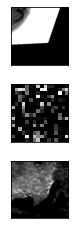

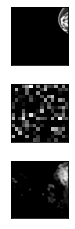

In [153]:
with torch.no_grad():
    number = 5
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = adv_example_sets
        copyback = test_examples[index]
        plt.imshow(copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + 1 + number)
        codes = adv_code_sets
        code_copyback = codes[index]
        plt.imshow(code_copyback.reshape(16,16))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + 6 + number)
        reconstruction = reconstruction_sets
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback.reshape(height, width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        out_path = "adv_output"+str(i)+".png" 
        plt.savefig(out_path)
        plt.show()